
<div style="text-align: center; line-height: 0; padding-top: 9px;">
  <img src="https://databricks.com/wp-content/uploads/2018/03/db-academy-rgb-1200px.png" alt="Databricks Learning">
</div>



# Model Tracking with *MLflow*

In this demo, we will explore the capabilities of MLflow, a comprehensive framework for the complete machine learning lifecycle. MLflow provides tools for tracking experiments, packaging code into reproducible runs, and sharing and deploying models.

In this demo, **we will focus on tracking and logging components of MLflow**. First, we will demonstrate how to track an experiment with MLflow and show various custom logging features including logging parameters, metrics, figures and arbitrary artifacts.

**Learning Objectives:**

*By the end of this demo, you will be able to*;

* Manually log parameters, metrics, models, and figures with MLflow tracking.

* Review an experiment using the MLflow UI.

* Train a model using a Feature Store table as the modeling set.

* Log training dataset with model in MLFlow



## REQUIRED - SELECT CLASSIC COMPUTE
Before executing cells in this notebook, please select your classic compute cluster in the lab. Be aware that **Serverless** is enabled by default.
Follow these steps to select the classic compute cluster:
1. Navigate to the top-right of this notebook and click the drop-down menu to select your cluster. By default, the notebook will use **Serverless**.
1. If your cluster is available, select it and continue to the next cell. If the cluster is not shown:
   - In the drop-down, select **More**.
   - In the **Attach to an existing compute resource** pop-up, select the first drop-down. You will see a unique cluster name in that drop-down. Please select that cluster.
  
**NOTE:** If your cluster has terminated, you might need to restart it in order to select it. To do this:
1. Right-click on **Compute** in the left navigation pane and select *Open in new tab*.
1. Find the triangle icon to the right of your compute cluster name and click it.
1. Wait a few minutes for the cluster to start.
1. Once the cluster is running, complete the steps above to select your cluster.

## Requirements

Please review the following requirements before starting the lesson:

* To run this notebook, you need to use one of the following Databricks runtime(s): **16.3.x-cpu-ml-scala2.12**

## MLFlow with Unity Catalog

Databricks has support for MLflow with Unity Catalog (UC) integration and workspace based classic version. Although we won't go into the details of MLflow with UC in this demo, we will enable it. This means **models will be registered to UC**.


## Classroom Setup

Before starting the demo, run the provided classroom setup script. This script will define configuration variables necessary for the demo. Execute the following cell:

In [0]:
%run ../Includes/Classroom-Setup-1.2

  Using cached databricks_sdk-0.36.0-py3-none-any.whl.metadata (38 kB)
Using cached databricks_sdk-0.36.0-py3-none-any.whl (569 kB)
  Attempting uninstall: databricks-sdk
    Found existing installation: databricks-sdk 0.30.0
    Not uninstalling databricks-sdk at /databricks/python3/lib/python3.12/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-854ce2f8-5dd1-4c85-8d7d-a44bab794c98
    Can't uninstall 'databricks-sdk'. No files were found to uninstall.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


2025/08/07 03:01:53 INFO databricks.ml_features._compute_client._compute_client: Setting columns ['unique_id'] of table 'dbacademy.labuser11091541_1754532261.diabetes_binary' to NOT NULL.
2025/08/07 03:01:54 INFO databricks.ml_features._compute_client._compute_client: Setting Primary Keys constraint ['unique_id'] on table 'dbacademy.labuser11091541_1754532261.diabetes_binary'.
2025/08/07 03:02:01 INFO databricks.ml_features._compute_client._compute_client: Created feature table 'dbacademy.labuser11091541_1754532261.diabetes_binary'.


**Other Conventions:**

Throughout this demo, we'll refer to the object `DA`. This object, provided by Databricks Academy, contains variables such as your username, catalog name, schema name, working directory, and dataset locations. Run the code block below to view these details:

In [0]:
print(f"Username:          {DA.username}")
print(f"Catalog Name:      {DA.catalog_name}")
print(f"Schema Name:       {DA.schema_name}")
print(f"Working Directory: {DA.paths.working_dir}")
print(f"User DB Location:  {DA.paths.datasets}")

Username:          labuser11091541_1754532261@vocareum.com
Catalog Name:      dbacademy
Schema Name:       labuser11091541_1754532261
Working Directory: /Volumes/dbacademy/ops/labuser11091541_1754532261@vocareum_com
User DB Location:  NestedNamespace (california_housing='/Volumes/dbacademy_california_housing/v02', cdc_diabetes='/Volumes/dbacademy_cdc_diabetes/v01', telco='/Volumes/dbacademy_telco/v01', banking='/Volumes/dbacademy_banking/v01')


## Prepare Dataset


### Load Dataset
In this section, we will leverage the Feature Store to load the dataset for our machine learning experiment. Instead of directly reading from a CSV file, we will use the Feature Store setup to create a feature table and then read the data from it. This approach enhances reproducibility and ensures consistency in the datasets used for training and testing.



In [0]:
import mlflow
feature_dataset = mlflow.data.load_delta(
    table_name = f"{DA.catalog_name}.{DA.schema_name}.diabetes_binary", 
    name = "diabetes_binary"
)   
feature_data_pd = feature_dataset.df.toPandas()
# Drop the 'unique_id' column
feature_data_pd = feature_data_pd.drop("unique_id", axis=1)

In [0]:
display(feature_data_pd)

Diabetes_binary HighBP HighChol CholCheck BMI Smoker Stroke HeartDiseaseorAttack PhysActivity Fruits Veggies HvyAlcoholConsump AnyHealthcare NoDocbcCost GenHlth MentHlth PhysHlth DiffWalk Sex Age Education Income 0.0 1.0 0.0 1.0 26.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 3.0 5.0 30.0 0.0 1.0 4.0 6.0 8.0 0.0 1.0 1.0 1.0 26.0 1.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 3.0 0.0 0.0 0.0 1.0 12.0 6.0 8.0 0.0 0.0 0.0 1.0 26.0 0.0 0.0 0.0 1.0 1.0 1.0 0.0 1.0 0.0 1.0 0.0 10.0 0.0 1.0 13.0 6.0 8.0 0.0 1.0 1.0 1.0 28.0 1.0 0.0 0.0 1.0 1.0 1.0 0.0 1.0 0.0 3.0 0.0 3.0 0.0 1.0 11.0 6.0 8.0 0.0 0.0 0.0 1.0 29.0 1.0 0.0 0.0 1.0 1.0 1.0 0.0 1.0 0.0 2.0 0.0 0.0 0.0 0.0 8.0 5.0 8.0 0.0 0.0 0.0 1.0 18.0 0.0 0.0 0.0 1.0 1.0 1.0 0.0 0.0 0.0 2.0 7.0 0.0 0.0 0.0 1.0 4.0 7.0 0.0 0.0 1.0 1.0 26.0 1.0 0.0 0.0 1.0 1.0 1.0 1.0 1.0 0.0 1.0 0.0 0.0 0.0 1.0 13.0 5.0 6.0 0.0 0.0 0.0 1.0 31.0 1.0 0.0 0.0 0.0 1.0 1.0 0.0 1.0 0.0 4.0 0.0 0.0 0.0 1.0 6.0 4.0 3.0 0.0 0.0 0.0 1.0 32.0 0.0 0.0 0.0 1.0 1.0 1.0 0.0 1.0 0.0 3.0 0.0 0.0 0.0 0.0 3.0 6.0 8.0 0.0 0.0 0.0 1.0 27.0 1.0 0.0 0.0 0.0 1.0 1.0 0.0 1.0 0.0 3.0 0.0 6.0 0.0 1.0 6.0 4.0 4.0 0.0 1.0 1.0 1.0 24.0 1.0 0.0 1.0 1.0 1.0 1.0 0.0 1.0 0.0 3.0 0.0 4.0 0.0 0.0 12.0 4.0 6.0 0.0 0.0 0.0 1.0 21.0 0.0 0.0 0.0 1.0 1.0 1.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 1.0 4.0 6.0 8.0 0.0 1.0 1.0 1.0 27.0 0.0 0.0 0.0 1.0 1.0 1.0 0.0 1.0 0.0 2.0 0.0 0.0 0.0 1.0 7.0 6.0 8.0 0.0 1.0 0.0 1.0 58.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 1.0 0.0 3.0 3.0 3.0 0.0 1.0 10.0 4.0 6.0 0.0 0.0 1.0 1.0 29.0 1.0 0.0 0.0 1.0 1.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 1.0 0.0 10.0 5.0 1.0 0.0 0.0 0.0 1.0 18.0 1.0 0.0 0.0 1.0 1.0 0.0 0.0 1.0 0.0 3.0 0.0 0.0 0.0 0.0 10.0 4.0 6.0 0.0 0.0 0.0 1.0 30.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 2.0 0.0 0.0 0.0 0.0 9.0 5.0 7.0 0.0 0.0 0.0 1.0 30.0 1.0 0.0 0.0 1.0 1.0 1.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 1.0 10.0 6.0 7.0 0.0 0.0 0.0 1.0 20.0 0.0 0.0 0.0 1.0 1.0 1.0 0.0 1.0 0.0 2.0 0.0 0.0 0.0 0.0 8.0 6.0 8.0 0.0 1.0 0.0 1.0 26.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 1.0 3.0 0.0 15.0 0.0 1.0 7.0 5.0 5.0 0.0 0.0 0.0 1.0 22.0 0.0 0.0 0.0 1.0 1.0 1.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 6.0 6.0 8.0 0.0 1.0 0.0 1.0 29.0 1.0 0.0 0.0 1.0 1.0 1.0 0.0 1.0 0.0 5.0 0.0 30.0 0.0 1.0 10.0 5.0 8.0 0.0 0.0 0.0 1.0 22.0 0.0 0.0 0.0 1.0 0.0 1.0 1.0 1.0 0.0 2.0 0.0 0.0 0.0 0.0 8.0 6.0 8.0 0.0 0.0 0.0 1.0 30.0 0.0 0.0 0.0 1.0 1.0 1.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 9.0 4.0 6.0 0.0 0.0 1.0 1.0 27.0 0.0 0.0 0.0 1.0 1.0 1.0 0.0 1.0 0.0 3.0 4.0 30.0 0.0 0.0 10.0 4.0 3.0 0.0 0.0 1.0 1.0 28.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 2.0 2.0 1.0 0.0 1.0 8.0 5.0 8.0 0.0 1.0 0.0 1.0 20.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 2.0 0.0 3.0 0.0 0.0 12.0 6.0 7.0 0.0 1.0 1.0 1.0 32.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 4.0 0.0 4.0 0.0 0.0 9.0 4.0 6.0 0.0 0.0 0.0 1.0 38.0 0.0 0.0 0.0 1.0 1.0 1.0 0.0 1.0 0.0 2.0 2.0 2.0 0.0 0.0 6.0 5.0 7.0 0.0 0.0 1.0 1.0 40.0 1.0 0.0 0.0 1.0 1.0 1.0 0.0 1.0 0.0 2.0 0.0 0.0 0.0 0.0 7.0 5.0 8.0 0.0 1.0 1.0 1.0 24.0 1.0 0.0 0.0 1.0 1.0 1.0 0.0 1.0 0.0 4.0 30.0 14.0 1.0 0.0 4.0 5.0 1.0 0.0 0.0 0.0 1.0 24.0 1.0 0.0 0.0 1.0 1.0 1.0 0.0 1.0 0.0 2.0 5.0 0.0 0.0 0.0 3.0 5.0 3.0 0.0 0.0 0.0 1.0 20.0 0.0 0.0 0.0 1.0 1.0 1.0 0.0 1.0 0.0 3.0 0.0 2.0 0.0 1.0 4.0 4.0 7.0 0.0 0.0 0.0 1.0 20.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 4.0 0.0 4.0 0.0 0.0 4.0 5.0 2.0 0.0 1.0 1.0 1.0 29.0 1.0 0.0 1.0 1.0 1.0 1.0 0.0 1.0 0.0 2.0 0.0 0.0 0.0 1.0 11.0 5.0 6.0 0.0 0.0 1.0 1.0 24.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 1.0 20.0 0.0 0.0 0.0 9.0 4.0 6.0 0.0 0.0 0.0 1.0 25.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 2.0 0.0 0.0 0.0 1.0 5.0 6.0 8.0 0.0 0.0 0.0 1.0 36.0 1.0 0.0 0.0 1.0 1.0 1.0 0.0 1.0 0.0 2.0 0.0 0.0 0.0 1.0 7.0 6.0 6.0 0.0 0.0 1.0 1.0 31.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 2.0 0.0 0.0 0.0 1.0 6.0 5.0 8.0 0.0 0.0 1.0 1.0 27.0 1.0 0.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 1.0 11.0 5.0 8.0 0.0 0.0 0.0 1.0 26.0 0.0 0.0 0.0 1.0 1.0 1.0 1.0 1.0 0.0 3.0 1.0 0.0 0.0 0.0 8.0 5.0 8.0 0.0 0.0 1.0 1.0 27.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 2.0 0.0 0.0 0.0 1.0 8.0 6.0 8.0 0.0 1.0 1.0 1.0 47.0 1.0 0.

In [0]:
import pandas as pd

# Convert all columns in the DataFrame to the 'double' data type
for column in feature_data_pd.columns:
    feature_data_pd[column] = feature_data_pd[column].astype("double")

# If you want to see the updated types
print(feature_data_pd.dtypes)

Diabetes_binary         float64
HighBP                  float64
HighChol                float64
CholCheck               float64
BMI                     float64
Smoker                  float64
Stroke                  float64
HeartDiseaseorAttack    float64
PhysActivity            float64
Fruits                  float64
Veggies                 float64
HvyAlcoholConsump       float64
AnyHealthcare           float64
NoDocbcCost             float64
GenHlth                 float64
MentHlth                float64
PhysHlth                float64
DiffWalk                float64
Sex                     float64
Age                     float64
Education               float64
Income                  float64
dtype: object


### Train / Test Split

Before proceeding with model training, it's essential to split the dataset into training and testing sets. This step ensures that the model is trained on one subset of the data and evaluated on an independent subset, providing a reliable estimate of its performance on new, unseen data.

In [0]:
from sklearn.model_selection import train_test_split

print(f"We have {feature_data_pd.shape[0]} records in our source dataset")

# split target variable into it's own dataset
target_col = "Diabetes_binary"
X_all = feature_data_pd.drop(labels=target_col, axis=1)
y_all = feature_data_pd[target_col]

# test / train split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=0.95, random_state=42)
print(f"We have {X_train.shape[0]} records in our training dataset")
print(f"We have {X_test.shape[0]} records in our test dataset")

We have 70692 records in our source dataset
We have 67157 records in our training dataset
We have 3535 records in our test dataset



## Fit and Log the Model

Now that we have our training and testing sets, let's fit a Decision Tree model to the training data. During this process, we will use MLflow to log various aspects of the model, including parameters, metrics, and the resulting model itself.

In [0]:
dtc_params = {
  'criterion': 'gini',
  'max_depth': 50,
  'min_samples_split': 20,
  'min_samples_leaf': 5
}

In this code, we use MLflow to start a run and log parameters such as the criterion and max_depth of the Decision Tree model. After fitting the model on the training data, we evaluate its performance on the test set and log the accuracy as a metric.

**🚨 Important:** MLflow autologging is **enabled by default on Databricks**. This means you don't need to do anything for supported libraries. In the next section, we are disabling it and manually log params, metrics etc. just demonstrate how to do it manually when you need to log any custom model info. For example, we use [`log_info`](https://mlflow.org/docs/2.20.3/python_api/mlflow.html?highlight=log_input#mlflow.log_input ) and [`log_metric`](https://mlflow.org/docs/2.20.3/python_api/mlflow.html?highlight=log_input#mlflow.log_metric), which is an API used for logging dataset metadata in MLflow and metrics of interest (e.g. F1-score), respectively. 

> 💡 ****Note: We won't define the `experiment name`, all *runs* generated in this notebook will be logged under the notebook title.****

In [0]:
import mlflow

# register models in UC
mlflow.set_registry_uri("databricks-uc")

In [0]:
from math import sqrt

import mlflow
import mlflow.data
import mlflow.sklearn
from mlflow.models.signature import infer_signature

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# set the path for mlflow experiment
mlflow.set_experiment(f"/Users/{DA.username}/Demo-1.2-Model-Tracking-with-MLflow")

# turn off autologging
mlflow.sklearn.autolog(disable=True)
model_name = f"{DA.catalog_name}.{DA.schema_name}.diabetes-predictions"

# start an MLFlow run
with mlflow.start_run(run_name="Model Tracking Demo") as run:
  # log the dataset
  mlflow.log_input(feature_dataset, context="source")
  mlflow.log_input(mlflow.data.from_pandas(X_train, source=feature_dataset.source), context="training")
  mlflow.log_input(mlflow.data.from_pandas(X_test, source=feature_dataset.source), context="test")

  # log our parameters
  mlflow.log_params(dtc_params)

  # fit our model
  dtc = DecisionTreeClassifier(**dtc_params)
  dtc_mdl = dtc.fit(X_train, y_train)

  # define model signature
  signature = infer_signature(X_all, y_all)

  # log the model
  mlflow.sklearn.log_model(
    sk_model = dtc_mdl, 
    artifact_path="model-artifacts",
    signature=signature,
    registered_model_name=model_name)
  
  # evaluate on the training set
  y_pred = dtc_mdl.predict(X_train)
  mlflow.log_metric("train_accuracy", accuracy_score(y_train, y_pred))
  mlflow.log_metric("train_precision", precision_score(y_train, y_pred))
  mlflow.log_metric("train_recall", recall_score(y_train, y_pred))
  mlflow.log_metric("train_f1", f1_score(y_train, y_pred))

  # evaluate on the test set
  y_pred = dtc_mdl.predict(X_test)
  mlflow.log_metric("test_accuracy", accuracy_score(y_test, y_pred))
  mlflow.log_metric("test_precision", precision_score(y_test, y_pred))
  mlflow.log_metric("test_recall", recall_score(y_test, y_pred))
  mlflow.log_metric("test_f1", f1_score(y_test, y_pred))

2025/08/07 03:02:10 INFO mlflow.tracking.fluent: Experiment with name '/Users/labuser11091541_1754532261@vocareum.com/Demo-1.2-Model-Tracking-with-MLflow' does not exist. Creating a new experiment.


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Successfully registered model 'dbacademy.labuser11091541_1754532261.diabetes-predictions'.


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Created version '1' of model 'dbacademy.labuser11091541_1754532261.diabetes-predictions'.
2025/08/07 03:02:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run Model Tracking Demo at: dbc-8b9f7bce-656b.cloud.databricks.com/ml/experiments/4297320214104915/runs/93f9b51664c2408ab8cbebb7f1293bd5.
2025/08/07 03:02:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: dbc-8b9f7bce-656b.cloud.databricks.com/ml/experiments/4297320214104915.


At this point we can access all model details using the **`run.info`** class.

In [0]:
run.info

<RunInfo: artifact_uri='dbfs:/databricks/mlflow-tracking/4297320214104915/93f9b51664c2408ab8cbebb7f1293bd5/artifacts', end_time=None, experiment_id='4297320214104915', lifecycle_stage='active', run_id='93f9b51664c2408ab8cbebb7f1293bd5', run_name='Model Tracking Demo', run_uuid='93f9b51664c2408ab8cbebb7f1293bd5', start_time=1754535730574, status='RUNNING', user_id=''>

## Log Model Artifacts

**In addition to logging parameters, metrics, and the model itself, we can also log artifacts—any files or data relevant to the run.** Let's set up an MLflow client to log artifacts after the run is completed.

In [0]:
from mlflow.client import MlflowClient

client = MlflowClient()

#### Log Confusion Matrix

The confusion matrix is a useful tool to visualize the classification performance of the model. It provides insights into the true positive, true negative, false positive, and false negative predictions. 

Let's create the confusion matrix and [**log it with MLflow** using **`log_figure`** function](https://mlflow.org/docs/2.20.3/traditional-ml/hyperparameter-tuning-with-child-runs/part2-logging-plots.html?highlight=log_figure ). This function logs in-memory figure objects directly to the current run.

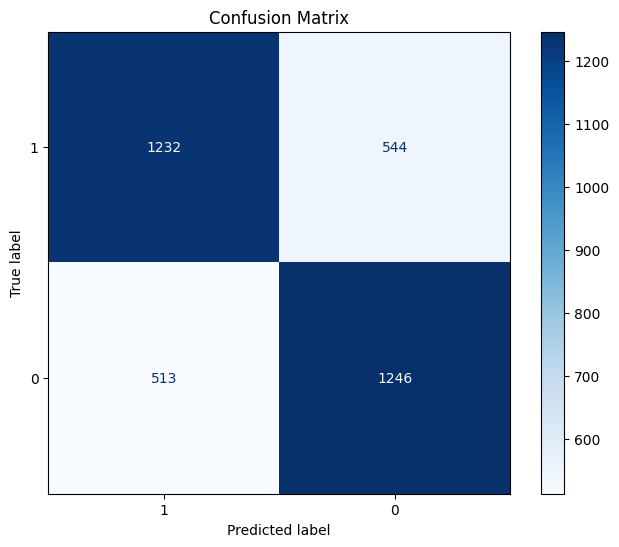

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Computing the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])

# Creating a figure object and axes for the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))

# Plotting the confusion matrix using the created axes
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot(cmap=plt.cm.Blues, ax=ax)

# Setting the title of the plot
ax.set_title('Confusion Matrix')

# Now 'fig' can be used with MLFlow's log_figure function
client.log_figure(run.info.run_id, figure=fig, artifact_file="confusion_matrix.png")

# Showing the plot here for demonstration
plt.show()

#### Log Feature Importance

Now, **let's examine and log the resulting model**. We'll extract and plot the feature importances inferred from the Decision Tree model to understand which data features are most critical for successful prediction.

Similar to the previous figure, we will use **`log_figure`** function.

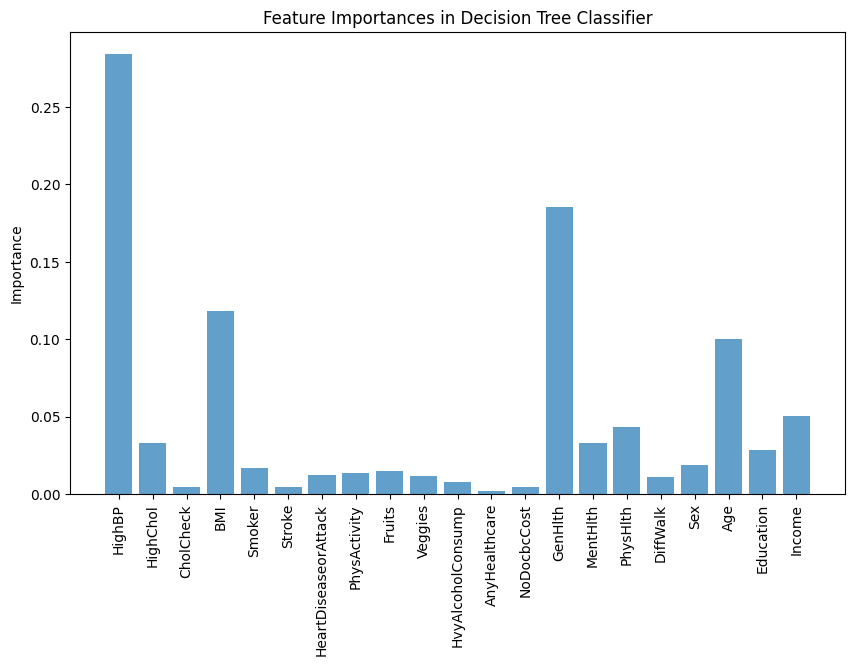

In [0]:
import numpy as np

# Retrieving feature importances
feature_importances = dtc_mdl.feature_importances_
feature_names = X_train.columns.to_list()

# Plotting the feature importances
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(feature_names))
ax.bar(x_pos, feature_importances, align='center', alpha=0.7)
ax.set_xticks(x_pos)
ax.set_xticklabels(feature_names, rotation=90)
ax.set_ylabel('Importance')
ax.set_title('Feature Importances in Decision Tree Classifier')

# log to mlflow
client.log_figure(run.info.run_id, figure=fig, artifact_file="feature_importances.png")

# display here
plt.show()

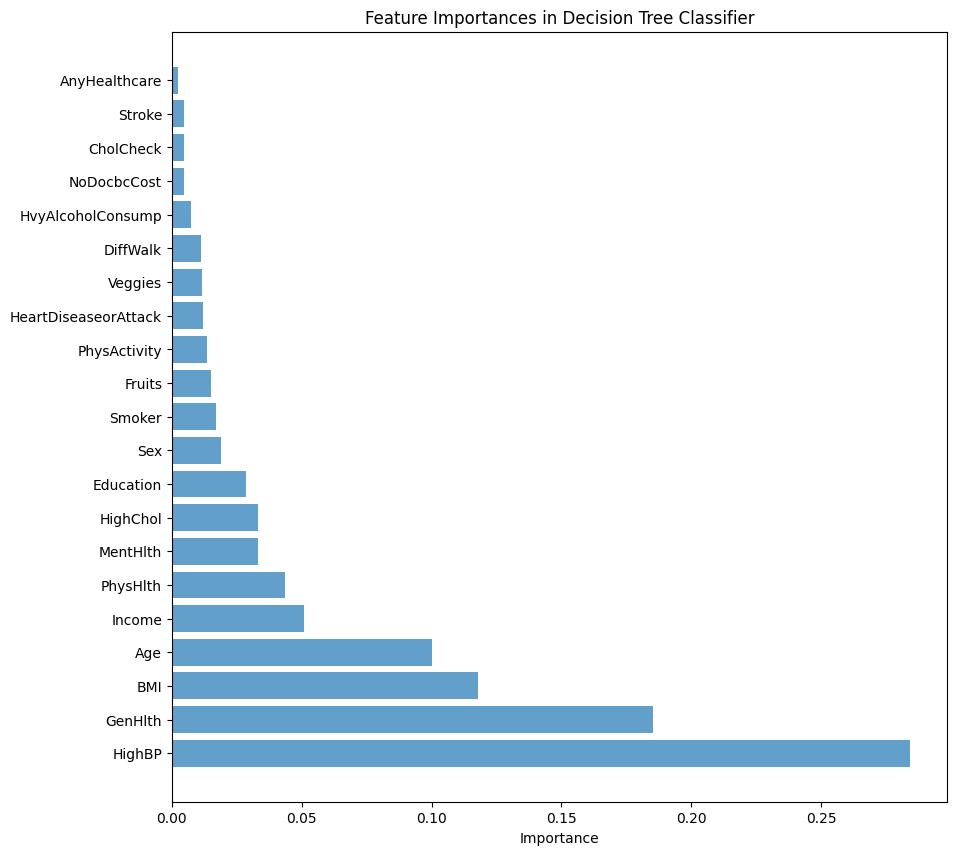

In [0]:
import numpy as np
import matplotlib.pyplot as plt

# Retrieving feature importances
feature_importances = dtc_mdl.feature_importances_
feature_names = X_train.columns.to_list()

# Sorting the feature importances in descending order
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_idx]
sorted_feature_names = [feature_names[i] for i in sorted_idx]

# Plotting the feature importances horizontally
fig, ax = plt.subplots(figsize=(10, 10))
y_pos = np.arange(len(sorted_feature_names))
ax.barh(y_pos, sorted_feature_importances, align='center', alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(sorted_feature_names)
ax.set_xlabel('Importance')
ax.set_title('Feature Importances in Decision Tree Classifier')

# Log to MLflow
client.log_figure(run.info.run_id, figure=fig, artifact_file="feature_importances.png")

# Display here
plt.show()

#### Log Tree Structure

Decision trees make splitting decisions on different features at different critical values, and visualizing the tree structure helps us understand the decision logic. We'll plot the branching tree structure for better interpretation.

We can get the tree in text format or as a graph. **To log the text format we will use `log_artifact` function.**

In [0]:
print(f"The fitted DecisionTreeClassifier model has {dtc_mdl.tree_.node_count} nodes and is up to {dtc_mdl.tree_.max_depth} levels deep.")

The fitted DecisionTreeClassifier model has 10043 nodes and is up to 32 levels deep.


This is a very large decision tree, printing out the full tree logic, we can see it is vast and sprawling:

In [0]:
from sklearn.tree import export_text

text_representation = export_text(dtc_mdl, feature_names=feature_names)
print(text_representation)

# save this to a local file
tree_struct_filename = "tree_structure.txt"
with open(tree_struct_filename,'w') as f:
  f.write(text_representation)

# log it to mlflow
client.log_artifact(run.info.run_id, tree_struct_filename)

|--- HighBP <= 0.50
|   |--- GenHlth <= 2.50
|   |   |--- Age <= 9.50
|   |   |   |--- BMI <= 28.50
|   |   |   |   |--- HighChol <= 0.50
|   |   |   |   |   |--- GenHlth <= 1.50
|   |   |   |   |   |   |--- Education <= 3.50
|   |   |   |   |   |   |   |--- Income <= 1.50
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- Income >  1.50
|   |   |   |   |   |   |   |   |--- PhysActivity <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |--- PhysActivity >  0.50
|   |   |   |   |   |   |   |   |   |--- AnyHealthcare <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |   |--- AnyHealthcare >  0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- Education >  3.50
|   |   |   |   |   |   |   |--- BMI <= 23.50
|   |   |   |   |   |   |   |   |--- HeartDiseaseorAttack <= 0.50
|   |   |   |   |   |   |   |   |   |--- Sex <= 0.50
|   |   |   

Let's create a visually better looking version of this tree and log it with MLflow.

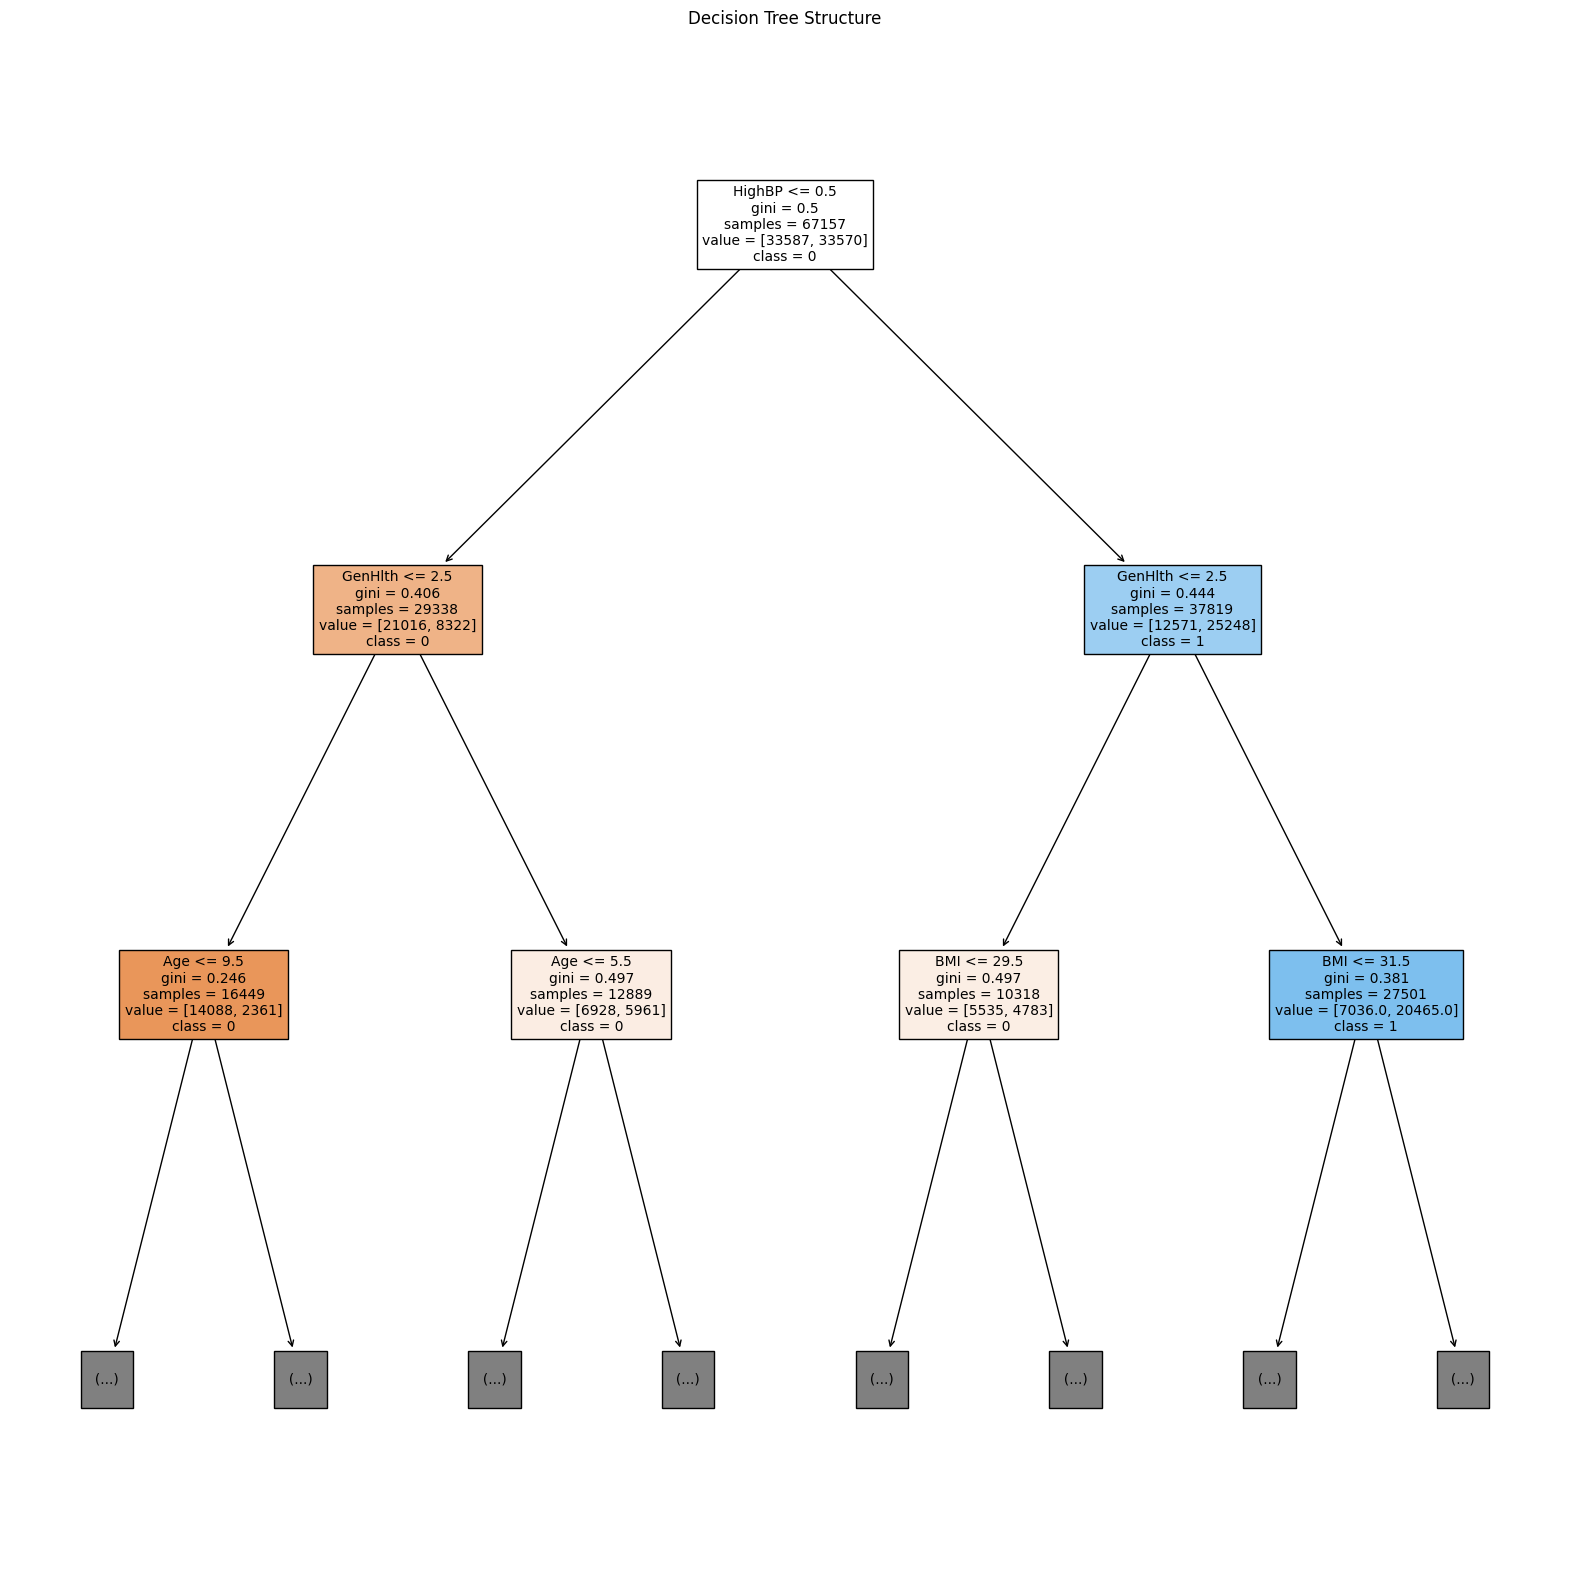

In [0]:
from sklearn.tree import plot_tree

# plot the tree structure
fig, ax = plt.subplots(figsize=(20,20))
plot_tree(dtc_mdl, 
          feature_names=feature_names,
          max_depth=2,
          class_names=['0', '1'], 
          filled=True,
          ax=ax)
ax.set_title('Decision Tree Structure')

# log it to mlflow
client.log_figure(run.info.run_id, fig, "decision_tree_structure.png")

# display it here
plt.show()

## Review the Model via the UI


To review the model and its details, follow these step-by-step instructions:

+ **Step 1: Go to the "Experiments" Section:**

  **Option 1:**
  - Click the Experiment icon <img src= "https://docs.databricks.com/en/_images/experiment.png" width=10> in the notebook’s right sidebar

  - In the Experiment Runs sidebar, click the <img src= "https://docs.databricks.com/en/_images/external-link.png" width=10> icon next to the date of the run. The MLflow Run page displays, showing details of the run, including parameters, metrics, tags, and a list of artifacts.

    ![quick-start-nb-experiment](../Includes/images/quick-start-nb-experiment1.png)

  **Option 2:**
  - Click on **Experiments** in the left sidebar.
  - Find the experiment name you specified in your MLflow run.
  - Click on the experiment name to view the runs within that experiment.
  - Locate the specific run you want to review.

+ **Step 2: Reviewing Artifacts and Metrics:**

  - Click on the run to see detailed information.
  - Navigate to the "Artifacts" tab to view logged artifacts.
  - Navigate to the "Model metrics" tab to view logged metrics.

+ **Step 3: Viewing Confusion Matrix Image:**

  - If you logged the confusion matrix as an artifact, you can find it in the "Artifacts" tab.
  - You may find a file named "confusion_matrix.png" (or the specified artifact file name).
  - Download or view the confusion matrix image.

+ **Step 4: View models in the UI:**
  - You can find details about the logged model under the <img src = "https://docs.databricks.com/en/_images/models-icon.png" width = 20> **Models** tab.
  - Look for the model name you specified in your MLflow run (e.g., "decision_tree_model").

+ **Explore Additional Options:**

  - You can explore other tabs and options in the MLflow UI to gather more insights, such as "Parameters," "Tags," and "Source."
These instructions will guide you through reviewing and exploring the tracked models using the MLflow UI, providing valuable insights into the experiment results and registered models.


## Conclusion

This demo guided us through the process of building, evaluating, and interpreting a Decision Tree model for classification tasks. We started by preparing and splitting the dataset, then proceeded to train the model using a Feature Store table. We manually logged key parameters, metrics, and artifacts using MLflow tracking, facilitating comprehensive experiment tracking and reproducibility. We examined and logged the model's performance through a confusion matrix, analyzed feature importances, and visualized the resulting tree structure. By leveraging MLflow, we demonstrated effective model tracking and experimentation management, contributing to a more informed and accountable machine learning workflow.


&copy; 2025 Databricks, Inc. All rights reserved. Apache, Apache Spark, Spark, the Spark Logo, Apache Iceberg, Iceberg, and the Apache Iceberg logo are trademarks of the <a href="https://www.apache.org/" target="blank">Apache Software Foundation</a>.<br/>
<br/><a href="https://databricks.com/privacy-policy" target="blank">Privacy Policy</a> | 
<a href="https://databricks.com/terms-of-use" target="blank">Terms of Use</a> | 
<a href="https://help.databricks.com/" target="blank">Support</a>